# Example of the rain event detection and rainfall retrieval using the nearby appraoch from Overeem et al. 2016

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import nearby_rain_retrival as nearby_rain
import nearby_wetdry as nearby_wetdry
import numpy as np
import pycomlink as pycml
import xarray as xr

import pycomlink.processing.wet_dry.nearby_wetdry as nearby_wetdry
import pycomlink.processing.nearby_rain_retrival as nearby_rain

#### Load data

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [2]:
pycml.io.examples.get_example_data_path()

data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + "/example_cml_data.nc")
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

#### Prepare data
Removing default values. This depends on the CML DAQ system.  
Interpolating small gaps in tsl and rsl time series increases data avilability.


In [3]:
cmls["rsl"] = cmls["rsl"].where(cmls.rsl > -99.9)
cmls["tsl"] = cmls["tsl"].where(cmls.tsl < 255.0)
cmls["rsl"] = cmls.rsl.interpolate_na(dim="time", method="linear", max_gap="5min")
cmls["tsl"] = cmls.tsl.interpolate_na(dim="time", method="linear", max_gap="5min")

#### Instanteanous to min-max data

Transfering instantaneous example data to 15 minute (interval) min-max data defining the minmal number of hours (min_hours) needed in a given time period (time period) to calssify wet and dry periods in the subsequent step. If no tsl data is available, a constant tsl has to be assumed and incoporated in CMLs.  

This step is not needed if min-max data is available.  

In [4]:
rstl = cmls.rsl - cmls.tsl
pmin = rstl.resample(
    time="15min",
).min()
pmax = rstl.resample(time="15min").max()

#### Calculate a distance matrix
Calculating distances between all cml endpoints and plotting the neighbors used for wet-dry classification depending on the distance

In [5]:
ds_dist = nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=cmls.cml_id.values,
    site_a_latitude=cmls.site_a_latitude,
    site_a_longitude=cmls.site_a_longitude,
    site_b_latitude=cmls.site_b_latitude,
    site_b_longitude=cmls.site_b_longitude,
)

500it [00:01, 354.18it/s]


In [6]:
r = 15  # radius in km
ds_dist["within_r"] = (
    (ds_dist.a_to_all_a < r)
    & (ds_dist.a_to_all_b < r)
    & (ds_dist.b_to_all_a < r)
    & (ds_dist.b_to_all_b < r)
)

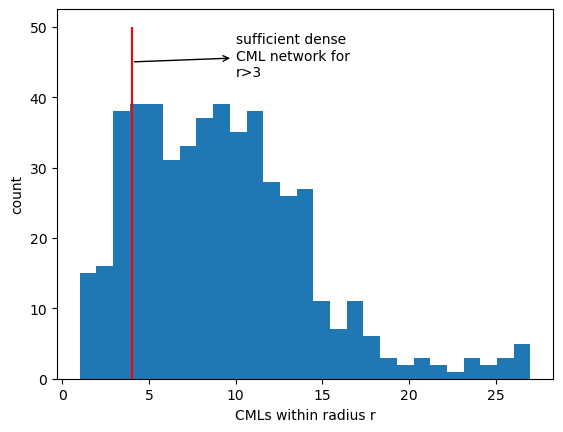

In [7]:
ds_dist.within_r.sum(dim="cml_id2").plot.hist(
    bins=int(ds_dist.within_r.sum(dim="cml_id2").max())
)
plt.vlines(4, ymin=0, ymax=50, color="red")
plt.annotate(
    text="sufficient dense\nCML network for\nr>3",
    xy=(4, 45),
    xytext=(10, 43),
    arrowprops=dict(arrowstyle="<-"),
)
plt.xlabel("CMLs within radius r")
plt.ylabel("count");

#### Classification of wet and dry time steps
using default paramters from Overeem et al. (2016)

In [8]:
wet, F = nearby_wetdry.nearby_wetdry(
    pmin=pmin,
    ds_dist=ds_dist,
    radius=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
    interval=15,
    timeperiod=24,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.58it/s]


#### Plotting instantaneous data , min-max data and the rain event detection from the nearby wetdry approach

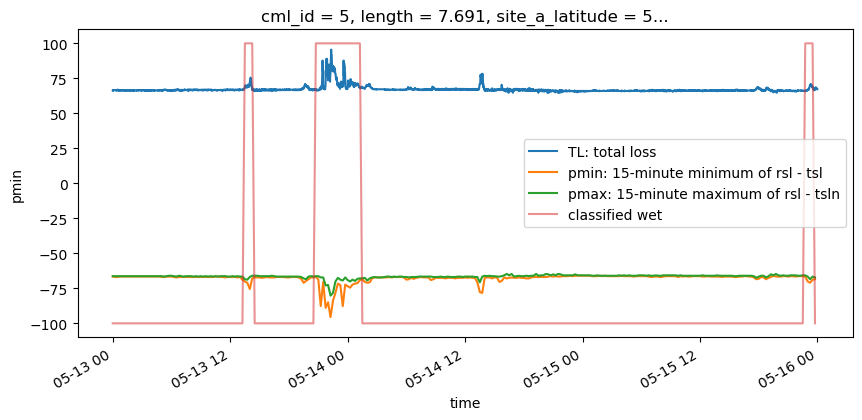

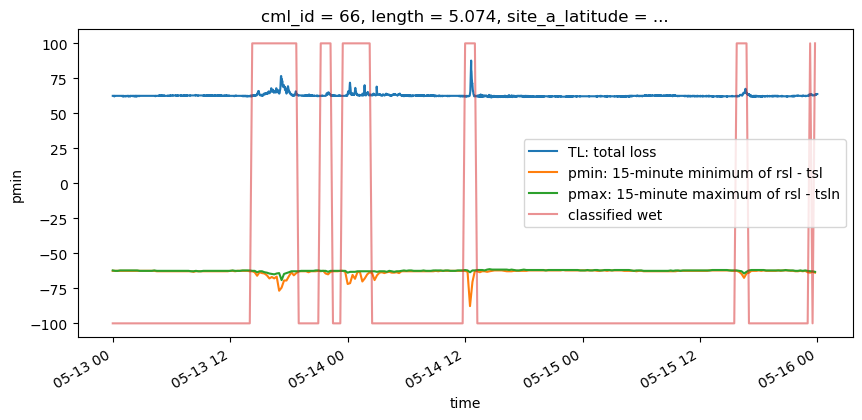

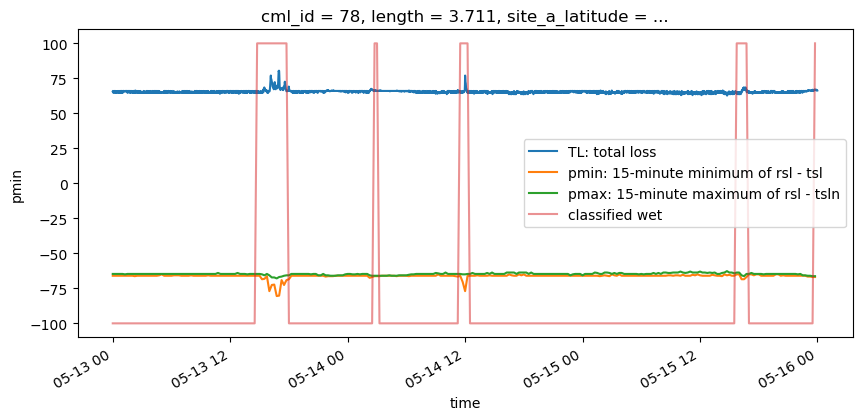

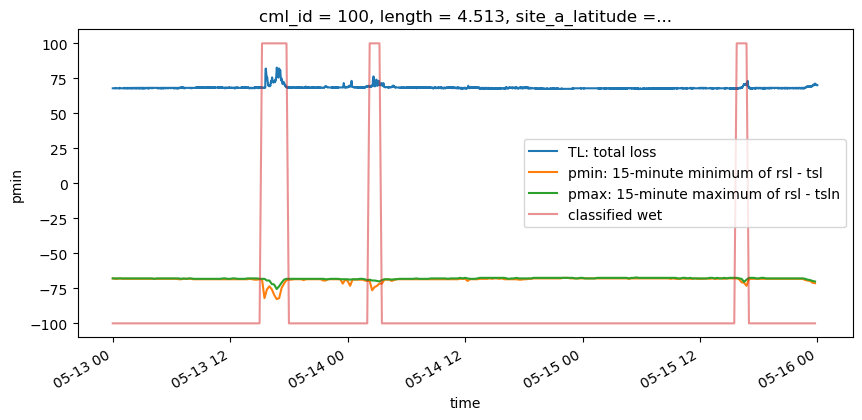

In [9]:
t_start, t_end = "2018-05-13", "2018-05-15"
for cmlid in ["5", "66", "78", "100"]:
    (cmls.sel(cml_id=cmlid).tsl - cmls.sel(cml_id=cmlid).rsl).isel(channel_id=0).sel(
        time=slice(t_start, t_end)
    ).plot(figsize=(10, 4), label="TL: total loss")
    pmin.sel(cml_id=cmlid, time=slice(t_start, t_end)).isel(channel_id=0).plot(
        label="pmin: 15-minute minimum of rsl - tsl"
    )
    pmax.sel(cml_id=cmlid, time=slice(t_start, t_end)).isel(channel_id=0).plot(
        label="pmax: 15-minute maximum of rsl - tsln"
    )
    (
        (wet.isel(channel_id=0).sel(cml_id=cmlid, time=slice(t_start, t_end)) * 200)
        - 100
    ).plot(label="classified wet", alpha=0.5)

    plt.legend()

#### Baseline estimation (pref)
The baseline is set to the rolling median of the average of pmin and pmax during the last n_average_dry time steps. Default is 24 hours.  
If pmax is not available e.g. because the min-max data is derived from instanteanous sampled CML data and has the same temporal resolution as the instanteanous CML data, substitute pmax with pmin so pmin and pmax are identical.

In [10]:
pref = nearby_rain.nearby_determine_reference_level(pmin, pmax, wet, n_average_dry=96)

#### Correction if min-max data 


In [12]:
p_c_min, p_c_max = nearby_rain.nearby_correct_received_signals(pmin, pmax, wet, pref)

#### Calculate rain rates from attenuation data 
Also, correcting for wet antenna attenuation and setting the alpha value which defines how close to the minimum attenuation of each intervall the rain rate should be set

In [13]:
R = nearby_rain.nearby_rainfall_retrival(
    pref,
    p_c_min,
    p_c_max,
    F,
    length=pmin.length,
    f_GHz=pmin.frequency / 1e9,
    pol=pmin.polarization,
    waa_max=2.3,
    alpha=0.33,
    F_value_correction=True,
)

#### Compare derived rain rates with reference data
As reference, path-averaged rain rates along the CMLs paths from RADKLIM-YW are provided. This data has a temporal resolution of 5 minutes and is resampled to 15 minute rainfall intensities. Here CML timeseries are compared individually against reference timeseries. Then we resample all cml data und prepare a scatterplot between CML and reference data. Finally some metrics are claculated. (for simplicity only channel 1 is evaluated here)

In [14]:
path_ref = xr.open_dataset(data_path + "/example_path_averaged_reference_data.nc")

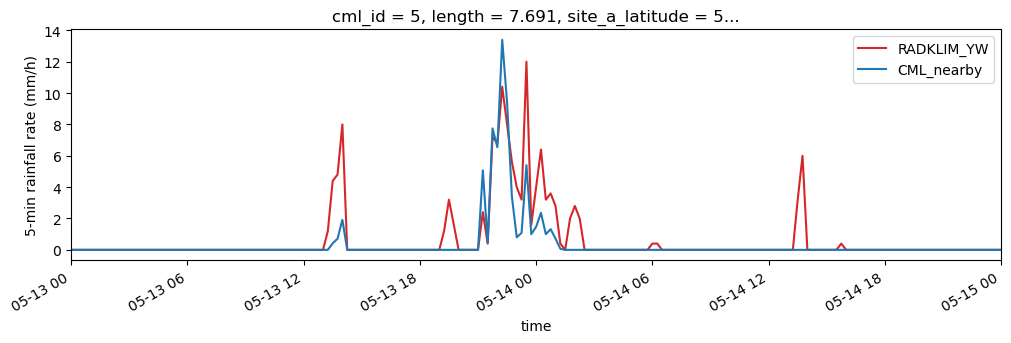

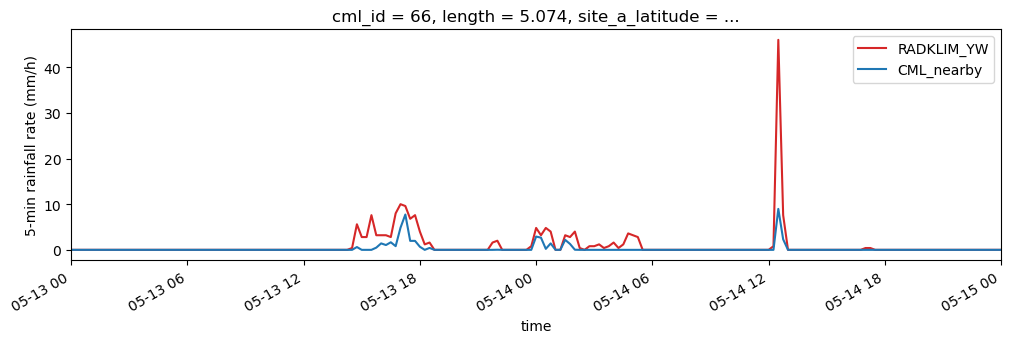

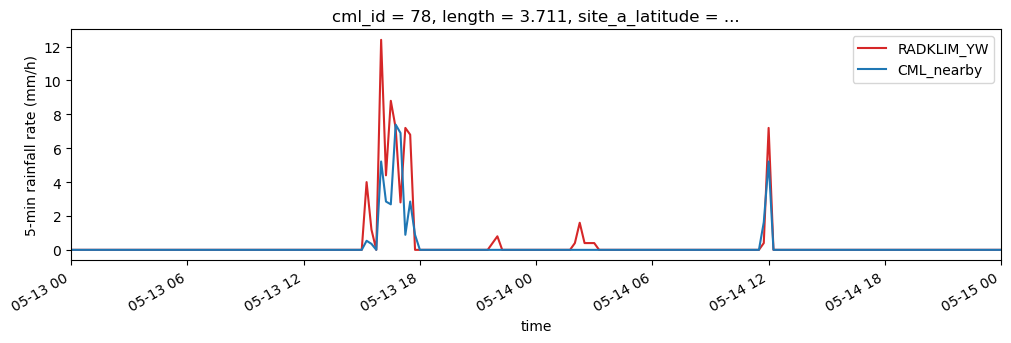

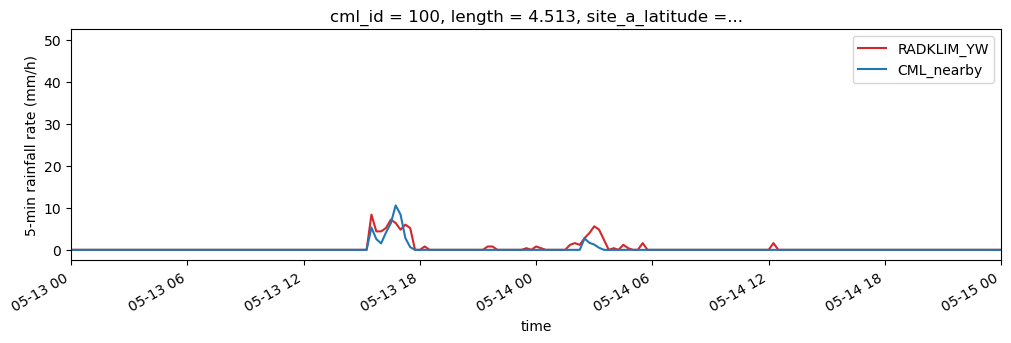

In [15]:
for i in ["5", "66", "78", "100"]:
    # Plot reference rainfall amount (converted to 15-minute rainfall rate)
    (path_ref.sel(cml_id=i).rainfall_amount.resample(time="15min").sum() * 4).plot(
        label="RADKLIM_YW", color="C3", figsize=(12, 3)
    )
    # Plot 15-minute mean rainfall rates from CMLs
    (R.sel(cml_id=i, channel_id="channel_1")).plot(
        x="time", label="CML_nearby", color="C0"
    )

    plt.xlim(np.datetime64("2018-05-13"), np.datetime64("2018-05-15"))
    plt.ylabel("5-min rainfall rate (mm/h)")
    plt.legend();